In [1]:
!pip install scikit-learn glob2 tqdm pesq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 15.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 586.8 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 6.6 MB/s eta 0:00:0000:01
  Created wheel for glob2: filename=glob2-0.7-py2.py3-none-any.whl size=9301 sha256=93bce95e8cd9c29e17069fe306781a2c7db51c838248793d9163a6159b337919
  Stored in directory: /root/.cache/pip/wheels/95/59/ed/52469ecfae47a78c25f11bcb49db42ff84629df01861876883
  Created wheel for pesq: filename=pesq-0.0.4-cp38-cp38-linux_x86_64.whl size=264950 sha256=27e4d0f5345a34473cc4269c9c3adca76f873ff98e0eaa4078646d74216dbc09
  Stored in directory: /root/.cache/pip/wheels/be/50/3f/1e20ce10f2e57d3481b488245b0f05f013602dd6dca0a67d18
Successfully built glob2 pesq

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip i

In [1]:
import os

import numpy as np

# Definir o nível de log do TensorFlow para ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Activation, Dropout, Conv1D, Conv1DTranspose, MaxPooling1D, concatenate, Concatenate, LSTM, Dense, SimpleRNN, BatchNormalization, Dropout, BatchNormalization, Add, Flatten, UpSampling1D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LayerNormalization, Dropout, MultiHeadAttention, Conv2D, Conv2DTranspose, MaxPooling2D, Permute, Reshape, AveragePooling2D, GlobalAveragePooling2D, multiply, GlobalAveragePooling1D, Multiply
from tensorflow.keras import backend as K

# import sounddevice as sd
from scipy.signal import butter, filtfilt
from scipy.signal import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.io import wavfile
from glob2 import glob
from tqdm import tqdm
from pesq import pesq
import matplotlib.pyplot as plt


from utils import load_wav, generate_white_gaussian_noise, add_white_gaussian_noise, undersample_signal_with_antialiasing, somar_sinais, calculate_snr, calcular_componentes_fourier, reconstruir_sinal

In [2]:
try:
 device_name = os.environ['COLAB_TPU_ADDR']
 TPU_ADDRESS = 'grpc://' + device_name
 print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
 print('TPU not found')

gpu=tf.test.gpu_device_name()
if gpu=="":
  print("Computador sem GPU.")
else:
  print("Computador com GPU:",tf.test.gpu_device_name())
  from tensorflow.python.client import device_lib
  devices=device_lib.list_local_devices()
  print("Dispositivos:",[x.physical_device_desc for x in devices if x.physical_device_desc!=""])
print()

!lsb_release -a | grep "Description" #imprime qual é o sistema operacional
!echo

!cat /proc/cpuinfo | grep -E "model name|core" #especificações de CPU
!echo 

!cat /proc/meminfo  | grep "Mem" #especificações de RAM

TPU not found
Computador com GPU: /device:GPU:0
Dispositivos: ['device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1']

No LSB modules are available.
Description:	Ubuntu 20.04.5 LTS

model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 0
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 1
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 2
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 3
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 4
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 5
cpu cores	: 6

MemTotal:       16334176 kB
MemFree:         2002476 kB
MemAvailable:   10248048 kB


# Descrição do Código

O código apresenta uma função chamada `get_sounds_from_folder` que recebe um caminho de diretório e um padrão como entrada e retorna uma lista de arquivos de som que correspondem ao padrão dentro do diretório e de seus subdiretórios até uma profundidade máxima especificada.

Em seguida, o código define uma série de operações para carregar arquivos de som, processá-los e prepará-los para treinamento. Ele carrega arquivos de ruído e sons limpos, realiza uma série de transformações nesses sons (como subamostragem e remodelagem), e os armazena em listas.

Após isso, o código realiza algumas operações de pré-processamento nos dados, como normalização e ajuste de limites, e exibe informações sobre a forma (shape) e os valores máximo e mínimo dos sons limpos e dos ruídos.

Em seguida, é definida uma classe chamada `DataGenerator`, que contém três métodos: `generate_sample_pesq`, `generate_sample_completo` e `generate_sample_pre`. Esses métodos geram lotes de exemplos de treinamento a partir dos arquivos de som e ruído carregados anteriormente. Cada lote contém um conjunto de sons e ruídos, aos quais são aplicadas diversas transformações e cálculos, como adição de ruído, cálculo da nota PESQ e formatação dos dados para treinamento. Os lotes são retornados em forma de geradores para serem utilizados no treinamento de um modelo.

No geral, o código carrega sons e ruídos, realiza transformações nos dados e os prepara para treinamento, além de fornecer métodos para gerar lotes de exemplos de treinamento com diferentes configurações.

In [3]:
def get_sounds_from_folder(path, pattern):
    max_depth = 3  # replace with the maximum depth of subfolders to search

    sound_list = []

    for root, dirs, files in os.walk(path):
        depth = root[len(path) + len(os.path.sep):].count(os.path.sep)
        if depth < max_depth:
            for file in files:
                if file.endswith(pattern):#or file.endswith('.bin'):
                    wav_path = os.path.join(root, file)
                    sound_list.append(wav_path)
    
    return sound_list

In [4]:
base_shape_size = 2000

In [5]:
noise_files_dir = './ESC-50-master/audio/'

In [6]:
noise_files = os.listdir(noise_files_dir)

In [7]:
# Load noisy sounds

noise_sounds = []

for noise_file in tqdm(noise_files):
    noise_sound = load_wav(os.path.join(noise_files_dir, noise_file))
    noise_sound_under = undersample_signal_with_antialiasing(noise_sound, 44100, 8000)
    noise_sound_under = noise_sound_under[base_shape_size:base_shape_size*3]
    noise_sound_under = noise_sound_under.reshape(-1, base_shape_size)
    noise_sounds.append(noise_sound_under)

noise_sounds = np.array(noise_sounds).reshape(-1, base_shape_size)

# Verificar quais amostras da primeira dimensão têm valores fora do intervalo [-1, 1]
condicao = np.logical_or(noise_sounds > 1., noise_sounds < -1.)
# Verificar se há algum valor NaN
condicao_nan = np.isnan(noise_sounds)
# Verificar se há alguma condição verdadeira em qualquer uma das duas condições
condicao_final = np.logical_or(condicao, condicao_nan)
# Verificar se alguma condição é verdadeira em cada linha
linhas_invalidas = np.any(condicao_final, axis=1)

# Remover as amostras que atendem à condição
noise_sounds = noise_sounds[~linhas_invalidas]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:39<00:00, 51.03it/s]


In [8]:
clean_files = get_sounds_from_folder('./Base/', 'clean.wav')

In [9]:
# Load clean sounds

clean_sounds = np.empty((1, base_shape_size), np.float32)

for clean_file in tqdm(clean_files):
    clean_sound = load_wav(clean_file)
    clean_sound = clean_sound[:len(clean_sound) // base_shape_size * base_shape_size].reshape(-1, base_shape_size)
    clean_sounds = np.append(clean_sounds, clean_sound, axis=0)

# Verificar quais amostras da primeira dimensão têm valores fora do intervalo [-1, 1]
condicao = np.logical_or(clean_sounds > 1., clean_sounds < -1.)
# Verificar se há algum valor NaN
condicao_nan = np.isnan(clean_sounds)
# Verificar se há alguma condição verdadeira em qualquer uma das duas condições
condicao_final = np.logical_or(condicao, condicao_nan)
# Verificar se alguma condição é verdadeira em cada linha
linhas_invalidas = np.any(condicao_final, axis=1)

# Remover as amostras que atendem à condição
clean_sounds = clean_sounds[~linhas_invalidas]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5476/5476 [01:56<00:00, 46.93it/s]


In [10]:
print(clean_sounds.shape)
print(noise_sounds.shape)

(40786, 2000)
(3715, 2000)


In [11]:
print(np.max(clean_sounds))
print(np.max(noise_sounds))

1.0
0.99978256


In [12]:
print(np.min(clean_sounds))
print(np.min(noise_sounds))

-1.0
-0.99918973


In [13]:
train_split = 0.6
val_split = 0.2
test_split = 0.2

In [14]:
np.random.shuffle(clean_sounds)
np.random.shuffle(noise_sounds)

train_X = clean_sounds[:int(len(clean_sounds)*train_split)]
val_X = clean_sounds[int(len(clean_sounds)*train_split):int(len(clean_sounds)*(train_split + val_split))]
test_X = clean_sounds[int(len(clean_sounds)*(train_split + val_split)):]

In [15]:
train_X.shape

(24471, 2000)

In [16]:
class DataGenerator:
    def __init__(self, sound_files, noise_files):
        self.sound_files = sound_files
        self.noise_files = noise_files
        self.MIN_NOISE_LEVEL = 10
        self.MAX_NOISE_LEVEL = 30
        
    def normalize_array(self, array):
        min_val = np.min(array)
        max_val = np.max(array)
        normalized_array = (array - min_val) / (max_val - min_val)
        normalized_array = normalized_array * 2 - 1
        return normalized_array

    def generate_sample_pesq(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x_train = []
            y_train = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
                sound = self.normalize_array(sound)
                noise = self.normalize_array(noise)
                
                sr = np.random.randint(self.MIN_NOISE_LEVEL, self.MAX_NOISE_LEVEL, size=(1,)[0])
                noisy_sound = somar_sinais(sound, noise, sr)
                noisy_sound = self.normalize_array(noisy_sound)
                
#                 noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(5, 50, size=(1,)[0]))
#                 noisy_sound = self.normalize_array(noisy_sound)
    
                # Calcula a nota PESQ
                try:
                    pesq_score = pesq(8000, sound, noisy_sound, 'nb')
                except:
                    continue

                valor_min = -0.6
                valor_max = 4.6
                pesq_score = (pesq_score - valor_min) / (valor_max - valor_min)
                
                # Formata dados para treinamento
                original_sound = sound.reshape((base_shape_size, 1))
                d_sound = noisy_sound.reshape((base_shape_size, 1))
                
                merged_array = np.concatenate((original_sound, d_sound), axis=1)
                
                # Adiciona o exemplo ao lote de treinamento
                x_train.append(merged_array)
                y_train.append(pesq_score)
            
            yield np.array(x_train), np.array(y_train)
            
    def generate_sample_completo(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x1_train = []
            x2_train = []
            y_train = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
                sound = self.normalize_array(sound)
                noise = self.normalize_array(noise)

                sr = np.random.randint(self.MIN_NOISE_LEVEL, self.MAX_NOISE_LEVEL, size=(1,)[0])
                noisy_sound = somar_sinais(sound, noise, sr)
                noisy_sound = self.normalize_array(noisy_sound)
                
#                 noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(5, 50, size=(1,)[0]))
#                 noisy_sound = self.normalize_array(noisy_sound)

                # Calcula a nota PESQ
                try:
                    pesq_score = pesq(8000, sound, noisy_sound, 'nb')
                except:
                    continue
                # Calcula a nota PESQ
                pesq_score = min(1., pesq_score+0.2)
                
                # Formata dados para treinamento
                original_sound = sound.reshape((base_shape_size, 1))
                d_sound = noisy_sound.reshape((base_shape_size, 1))
                
#                 merged_array = np.concatenate((original_sound, d_sound), axis=1)
                
                # Adiciona o exemplo ao lote de treinamento
                x1_train.append(d_sound)
                x2_train.append(original_sound)
                y_train.append(pesq_score)
            
            yield [np.array(x1_train), np.array(x2_train)], np.array(y_train)

    def generate_sample_pre(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x1_train = []
            y_train = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
                sound = self.normalize_array(sound)
                noise = self.normalize_array(noise)

                sr = np.random.randint(self.MIN_NOISE_LEVEL, self.MAX_NOISE_LEVEL, size=(1,)[0])
                noisy_sound = somar_sinais(sound, noise, sr)
                noisy_sound = self.normalize_array(noisy_sound)
                
#                 noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(5, 30, size=(1,)[0]))
#                 # noisy_sound = add_white_gaussian_noise(sound, np.random.randint(5, 50, size=(1,)[0]))
#                 noisy_sound = self.normalize_array(noisy_sound)
                
                # Formata dados para treinamento
                original_sound = sound.reshape((base_shape_size, 1))
                d_sound = noisy_sound.reshape((base_shape_size, 1))
                
#                 original_sound, _ = calcular_componentes_fourier(original_sound)
#                 d_sound, _ = calcular_componentes_fourier(d_sound)
                
                # Adiciona o exemplo ao lote de treinamento
                x1_train.append(d_sound.reshape((base_shape_size, 2)))
                y_train.append(original_sound.reshape((base_shape_size, 2)))
            
            yield np.array(x1_train), np.array(y_train)

In [17]:
class PlotLossesCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.epochs = 0
        self.fig, self.ax = plt.subplots()

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.epochs += 1

        self.ax.clear()
        self.ax.plot(range(1, self.epochs+1), self.losses, label='training')
        self.ax.plot(range(1, self.epochs+1), self.val_losses, label='validation')
        self.ax.legend()
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.ax.set_title('Training and Validation Loss')

## Modelo para a PESQ

1. Uma função `cnn()` é definida para construir a arquitetura do modelo CNN.
2. O modelo é criado chamando `cnn()`, e um resumo do modelo é impresso.
3. Instâncias de `DataGenerator` são criadas para os dados de treinamento e validação.
4. O modelo é compilado com o otimizador 'adam' e a função de perda 'mse' (erro quadrático médio).
5. Parâmetros de treinamento são definidos, como tamanho do lote e etapas por época.
6. O treinamento começa com um loop que itera três vezes para três épocas.
7. Para cada época, um novo lote de validação é gerado usando o gerador de dados de validação.
8. O modelo é treinado usando o gerador de dados de treinamento, com as etapas por época, épocas, dados de validação e um callback para visualização de perda.
9. Após o treinamento, o modelo é salvo em um arquivo chamado 'pesq-generator-16.h5'.

In [20]:
def cnn():
    # Define the input shape
    input_shape = (base_shape_size, 2)

    # Define the model architecture
    input_layer = Input(shape=input_shape)

    conv1 = Conv1D(16, 17, activation='relu')(input_layer)
    conv1 = Conv1D(16, 17, activation='relu')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(32, 9, activation='relu')(pool1)
    conv2 = Conv1D(32, 9, activation='relu')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    
    conv3 = Conv1D(64, 3, activation='relu')(pool2)
    conv3 = Conv1D(64, 3, activation='relu')(conv3)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(128, 3, activation='relu')(pool2)
    conv3 = Conv1D(128, 3, activation='relu')(conv3)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    flatten = Flatten()(pool2)
    dense1 = Dense(64, activation='relu')(flatten)
    dense1 = Dense(64, activation='relu')(dense1)
    output_layer = Dense(1, activation='sigmoid')(dense1)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [21]:
# Crie uma instância do DataGenerator
data_generator_train = DataGenerator(train_X, noise_sounds)
data_generator_val = DataGenerator(val_X, noise_sounds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000, 2)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1984, 16)          560       
                                                                 
 conv1d_1 (Conv1D)           (None, 1968, 16)          4368      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 984, 16)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 976, 32)           4640      
                                                                 
 conv1d_3 (Conv1D)           (None, 968, 32)           9248      
                                                             

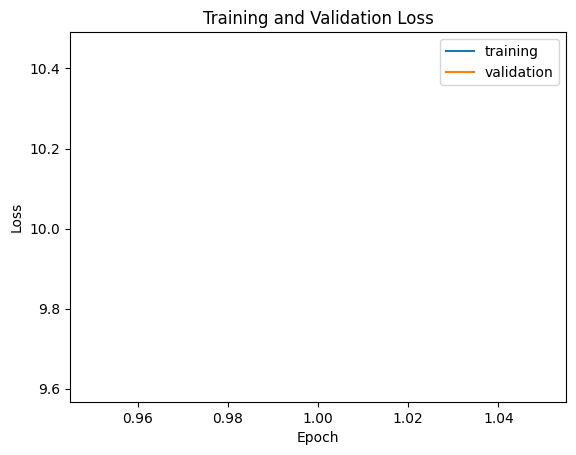

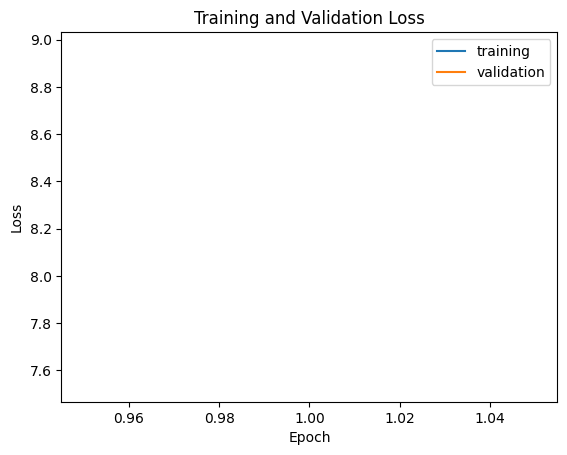

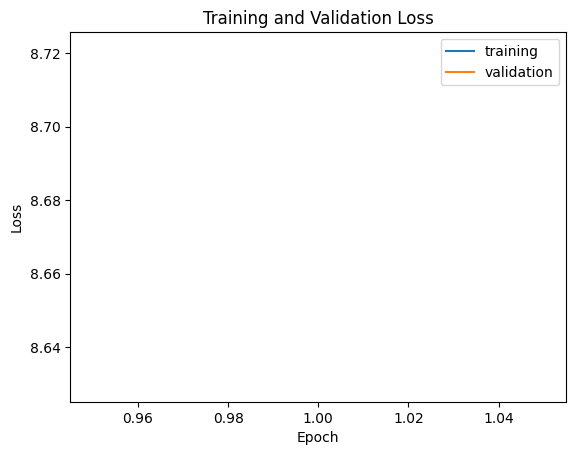

In [22]:
model = cnn()
model.summary()
model.compile(optimizer='adam', loss='mape',)

batch_size = 32
steps_per_epoch = len(train_X) // batch_size

print('Starting training')

for epoch in range(3):
    print(f"Epoch {epoch + 1}")
    
    # Gera um novo lote de validação para cada época
    validation_batch = next(data_generator_val.generate_sample_pesq(batch_size=batch_size))
    x_val, y_val = validation_batch
        
    model.fit(data_generator_train.generate_sample_pesq(batch_size=batch_size),
              steps_per_epoch=steps_per_epoch,
              epochs=1,
              validation_data=(x_val, y_val),
              callbacks=[PlotLossesCallback()]
            )

# score = model.evaluate(X_test, y_test, verbose=0)
# print(score)
model.save('pesq-generator-16.h5')

In [23]:
from keras import backend as K

K.clear_session()

## Pré treinamento da rede para remoção de ruído

Nesta etapa, estamos utilizando a arquitetura UNet de redes neurais para
montar um modelo para a remoção de ruído

In [18]:
def unet(inputs):

    # Encoder
    conv1 = Conv2D(64, 3, activation='tanh', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='tanh', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Middle
    conv3 = Conv2D(256, 3, activation='tanh', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='tanh', padding='same')(conv3)
    
    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = Conv2D(128, 3, activation='tanh', padding='same')(up1)
    merge1 = concatenate([conv2, up1], axis=3)
    conv4 = Conv2D(128, 3, activation='tanh', padding='same')(merge1)
    conv4 = Conv2D(128, 3, activation='tanh', padding='same')(conv4)
    
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = Conv2D(64, 3, activation='tanh', padding='same')(up2)
    merge2 = concatenate([conv1, up2], axis=3)
    conv5 = Conv2D(64, 3, activation='tanh', padding='same')(merge2)
    conv5 = Conv2D(64, 3, activation='tanh', padding='same')(conv5)
    
    # Output
    output = Conv2D(1, 1, activation='tanh')(conv5)
    output = Reshape((base_shape_size, 1))(output)

    return output

In [19]:
def squeeze_excite_block(input_tensor):
    filters = K.int_shape(input_tensor)[-1]
    se = GlobalAveragePooling1D()(input_tensor)
    se = Dense(filters // 16, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, filters))(se)
    scaled_input = multiply([input_tensor, se])
    return scaled_input

def attention_block(encoder_output, decoder_input):
    filters = K.int_shape(decoder_input)[-1]
    encoder_attention = Conv1D(filters, 1, activation='sigmoid', padding='same')(encoder_output)
    multiplied = multiply([encoder_attention, decoder_input])
    output = Add()([multiplied, decoder_input])
    return output

In [20]:
def big_unet(inputs, filter_size=3):
    # Encoder
    conv1 = Conv1D(32, filter_size, activation='relu', padding='same')(inputs)
    conv1 = Conv1D(32, filter_size, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(64, filter_size, activation='relu', padding='same')(pool1)
    conv2 = Conv1D(64, filter_size, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(128, filter_size, activation='relu', padding='same')(pool2)
    conv3 = Conv1D(128, filter_size, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    conv4 = Conv1D(256, filter_size, activation='relu', padding='same')(pool3)
    conv4 = Conv1D(256, filter_size, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling1D(pool_size=2)(drop4)

    conv5 = Conv1D(512, filter_size, activation='relu', padding='same')(pool4)
    conv5 = Conv1D(512, filter_size, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv1DTranspose(256, 2, strides=2, padding='same')(drop5)
    merge6 = concatenate([conv4, up6], axis=2)
    conv6 = Conv1D(256, filter_size, activation='relu', padding='same')(merge6)
    conv6 = Conv1D(256, filter_size, activation='relu', padding='same')(conv6)
    attention6 = squeeze_excite_block(conv6)  # Camada de atenção

    up7 = Conv1DTranspose(128, 2, strides=2, padding='same')(attention6)
    merge7 = concatenate([conv3, up7], axis=2)
    conv7 = Conv1D(128, filter_size, activation='relu', padding='same')(merge7)
    conv7 = Conv1D(128, filter_size, activation='relu', padding='same')(conv7)
    attention7 = squeeze_excite_block(conv7)  # Camada de atenção

    up8 = Conv1DTranspose(64, 2, strides=2, padding='same')(attention7)
    merge8 = concatenate([conv2, up8], axis=2)
    conv8 = Conv1D(64, filter_size, activation='relu', padding='same')(merge8)
    conv8 = Conv1D(64, filter_size, activation='relu', padding='same')(conv8)
    attention8 = squeeze_excite_block(conv8)  # Camada de atenção

    up9 = Conv1DTranspose(32, 2, strides=2, padding='same')(attention8)
    merge9 = concatenate([conv1, up9], axis=2)
    conv9 = Conv1D(32, filter_size, activation='relu', padding='same')(merge9)
    conv9 = Conv1D(32, filter_size, activation='relu', padding='same')(conv9)
    attention9 = squeeze_excite_block(conv9)  # Camada de atenção

    output = Conv1D(1, 1, activation='tanh')(attention9)
    # output = Reshape((base_shape_size, 1))(conv10)

    return output
    
# def big_unet(inputs):
#     # Encoder
#     conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
#     drop4 = Dropout(0.5)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#     conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
#     conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
#     drop5 = Dropout(0.5)(conv5)

#     # Decoder
#     up6 = Conv2DTranspose(256, 2, strides=(2, 3), padding='same')(drop5)
#     attention6 = attention_block(drop4, up6)  # Camada de atenção
#     merge6 = concatenate([attention6, up6], axis=3)
#     conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
#     conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)
#     se1 = squeeze_excite_block(conv6)  # Camada de SE

#     up7 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(se1)
#     attention7 = attention_block(conv3, up7)  # Camada de atenção
#     merge7 = concatenate([attention7, up7], axis=3)
#     conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
#     conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)
#     se2 = squeeze_excite_block(conv7)  # Camada de SE

#     up8 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(se2)
#     attention8 = attention_block(conv2, up8)  # Camada de atenção
#     merge8 = concatenate([attention8, up8], axis=3)
#     conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
#     conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)
#     se3 = squeeze_excite_block(conv8)  # Camada de SE

#     up9 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(se3)
#     attention9 = attention_block(conv1, up9)  # Camada de atenção
#     merge9 = concatenate([attention9, up9], axis=3)
#     conv9 = Conv2D(32, 3, activation='relu', padding='same')(merge9)
#     conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)
#     se4 = squeeze_excite_block(conv9)  # Camada de SE

#     conv10 = Conv2D(1, 1, activation='tanh')(se4)
#     output = Reshape((base_shape_size, 1))(conv10)
    
#     return output


In [22]:
def fcrn(input_layer):
    # Camadas de convolução
    conv1 = Conv1D(64, 3, activation='tanh', padding='same')(input_layer)
    conv1 = Conv1D(64, 3, activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    
    conv2 = Conv1D(128, 3, activation='tanh', padding='same')(pool1)
    conv2 = Conv1D(128, 3, activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    
    # Camada LSTM
    lstm = LSTM(256, return_sequences=True)(pool2)
    
    # Camadas de upsampling
    up1 = UpSampling1D(size=2)(lstm)
    up1 = Conv1D(128, 3, activation='tanh', padding='same')(up1)
    up1 = Conv1D(128, 3, activation='tanh', padding='same')(up1)

    add1 = Add()([conv2, up1])
    
    up2 = UpSampling1D(size=2)(add1)
    up2 = Conv1D(64, 3, activation='tanh', padding='same')(up2)
    up2 = Conv1D(64, 3, activation='tanh', padding='same')(up2)

    output1 = Add()([conv1, up2])

    output_layer = Conv1D(2, 1, activation='tanh')(output1)
    
    scaled_input = Multiply()([input_layer, output_layer])
    
    return scaled_input

In [23]:
# Função para normalizar entre -1 e 1
def normalize_output(x):
    x_min = K.min(x)
    x_max = K.max(x)
    new_min = -1
    new_max = 1
    normalized_output = (x - x_min) / (x_max - x_min) * (new_max - new_min) + new_min
    return normalized_output

In [ ]:
input_pre = Input(shape=(base_shape_size, 2))

output = fcrn(input_pre)
# output_pre = Add()([input_pre, output])
# output_pre = normalize_output(output_pre)

# output = big_unet(output_pre, filter_size=5)
# output_pre = Add()([output_pre, output])
# output_pre = normalize_output(output_pre)

# output = big_unet(output_pre, filter_size=7)
# output_pre = Add()([output_pre, output])
# output_pre = normalize_output(output_pre)

modelo_pre = Model(inputs=input_pre, outputs=output)

In [ ]:
modelo_pre.summary()

In [ ]:
# Crie uma instância do DataGenerator
data_generator_train_pre = DataGenerator(train_X, noise_sounds)
data_generator_val_pre = DataGenerator(val_X, noise_sounds)

In [ ]:
x_val[0, : , 0].shape

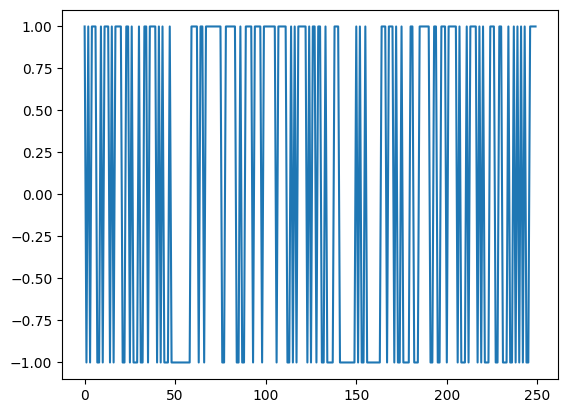

In [268]:
plt.plot(x_val[0, : , 0][0:250])

In [ ]:
modelo_pre.compile(optimizer='adam', loss='mse',)

batch_size = 32
steps_per_epoch = len(train_X) // batch_size

print('Starting training')

for epoch in range(5):
    print(f"Epoch {epoch + 1}")
    
    # Gera um novo lote de validação para cada época
    validation_batch = next(data_generator_val_pre.generate_sample_pre(batch_size=batch_size))
    x_val, y_val = validation_batch
    
    modelo_pre.fit(data_generator_train_pre.generate_sample_pre(batch_size=batch_size),
              steps_per_epoch=steps_per_epoch,
              epochs=1,
              validation_data=(x_val, y_val),
             )


In [186]:
modelo_pre.save('modelo-pre.h5')

In [187]:
data_generator_test = DataGenerator(test_X, noise_sounds)
x_test, y_test = next(data_generator_test.generate_sample_pre(batch_size=1))

In [188]:
sound = y_test[0]
noisy_sound = x_test[0]

In [189]:
# sound = load_wav('./Base/BR_00400/balsen3_clean.wav')
# noisy_sound = data_generator_train_pre.normalize_array(add_white_gaussian_noise(sound, 30))

# sound = sound[:len(sound) // base_shape_size * base_shape_size].reshape(-1, base_shape_size, 1)
# noisy_sound = noisy_sound[:len(noisy_sound) // base_shape_size * base_shape_size].reshape(-1, base_shape_size, 1)

In [190]:
print(np.min(noisy_sound))
print(np.max(noisy_sound))
print(noisy_sound.shape)
print(sound.shape)

-1.0
1.0
(2000, 1)
(2000, 1)


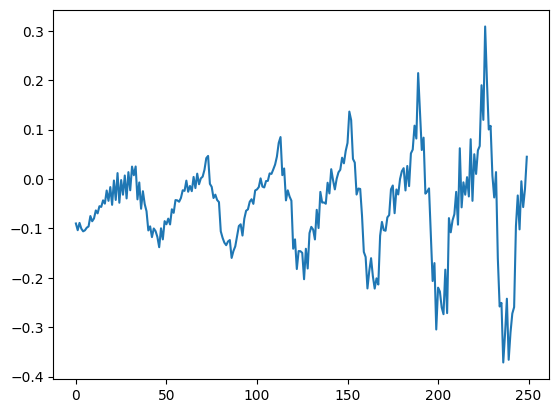

In [191]:
plt.plot(sound[250:500])

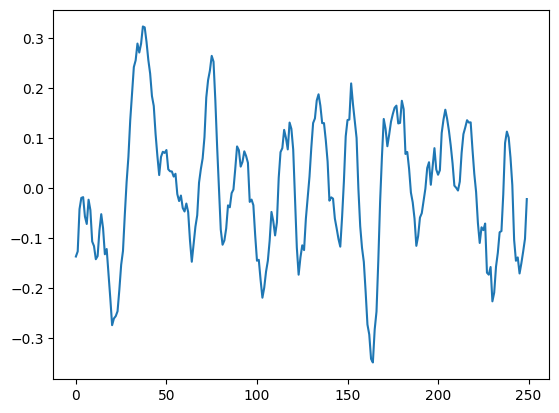

In [192]:
plt.plot(noisy_sound[250:500])

In [193]:
filtered = modelo_pre.predict(np.array(noisy_sound).reshape(1, 2000, 1))

1/1 [==============================] - 0s 462ms/step


In [194]:
filtered.shape

(1, 2000, 1)

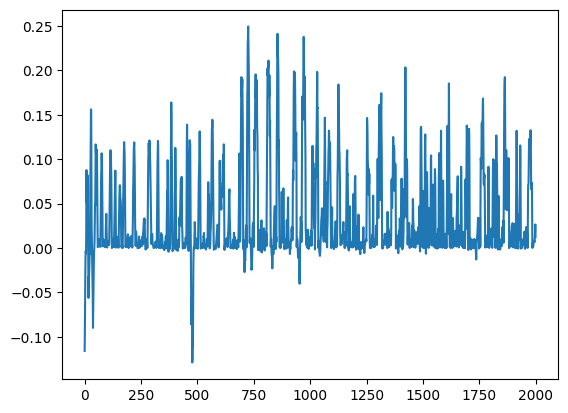

In [195]:
plt.plot(filtered[0])

In [196]:
print('SNR sinal ruidoso: {}'.format(calculate_snr(sound.reshape(-1), noisy_sound.reshape(-1))))
print('SNR sinal filtrado: {}'.format(calculate_snr(sound.reshape(-1), filtered.reshape(-1))))

SNR sinal ruidoso: -2.0026220994773483
SNR sinal filtrado: -0.27276843786239624


In [197]:
print('PESQ sinal ruidoso: {}'.format(pesq(8000, sound.reshape(-1), noisy_sound.reshape(-1), 'nb')))
print('PESQ sinal filtrado: {}'.format(pesq(8000, sound.reshape(-1), filtered.reshape(-1), 'nb')))

PESQ sinal ruidoso: 1.313280701637268
PESQ sinal filtrado: 1.3059918880462646


In [70]:
from utils import save_sound_to_wav

In [71]:
save_sound_to_wav(sound.reshape(-1), 'original.wav')
save_sound_to_wav(noisy_sound.reshape(-1), 'ruidoso.wav')
save_sound_to_wav(filtered.reshape(-1), 'filtrado.wav')

## Compilação dos modelos treinados para refinamento


In [ ]:
# Carregar o modelo treinado
modelo_treinado = load_model('pesq-generator-16.h5')

# Definir seus pesos como não treináveis
for layer in modelo_treinado.layers:
    layer.trainable = False

In [ ]:
modelo_pre = load_model('modelo-pre.h5')

In [ ]:
input_novo = Input(shape=(256, 24, 1))
input_concat = Input(shape=(base_shape_size, 1))

output_novo = modelo_pre(input_novo)
output_concat = concatenate([input_concat, output_novo], axis=-1)

completo = modelo_treinado(output_concat)

modelo_final = Model(inputs=[input_novo, input_concat], outputs=completo)

In [ ]:
# Crie uma instância do DataGenerator
data_generator_train = DataGenerator(train_X, noise_sounds)
data_generator_val = DataGenerator(val_X, noise_sounds)

In [ ]:
modelo_final.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 24, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 model_3 (Functional)           (None, 6144, 1)      7847041     ['input_7[0][0]']                
                                                                                                  
 input_8 (InputLayer)           [(None, 6144, 1)]    0           []                               
                                                                                                  
 concatenate_17 (Concatenate)   (None, 6144, 2)      0           ['model_3[0][0]',          

In [ ]:
validation_batch = next(data_generator_val.generate_sample_completo(batch_size=batch_size))
x_val, y_val = validation_batch

In [ ]:
x_val[0].shape

(16, 256, 24, 1)

Starting training
Epoch 1
  6/106 [>.............................] - ETA: 16s - loss: 1.0000

106/106 [==============================] - 31s 191ms/step - loss: 1.0000 - val_loss: 1.0000 - lr: 1.0000e-04
Epoch 2
  6/106 [>.............................] - ETA: 16s - loss: 1.0000

 54/106 [==============>...............] - ETA: 8s - loss: 1.0000

KeyboardInterrupt: ignored

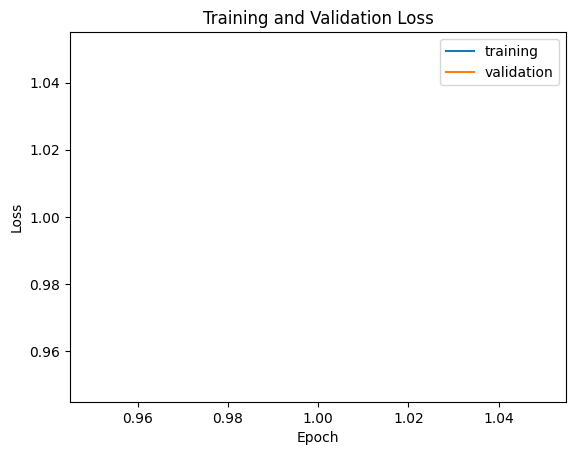

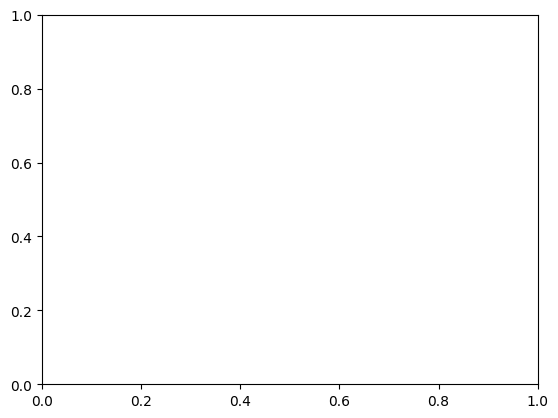

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2

# Definir taxa de aprendizado e fator de decaimento
learning_rate = 0.0001
decay_factor = 0.1

# Definir taxa de aprendizado para as camadas adicionais
additional_layers_lr = 0.001

# Definir regularização L2
l2_regularization = 0.01

# Compilar o modelo final com os ajustes
optimizer = Adam(learning_rate=learning_rate)
modelo_final.compile(optimizer=optimizer, loss='mse')

# Ajustar a taxa de aprendizado das camadas adicionais
for layer in modelo_final.layers:
    if layer.name.startswith('camadas_adicionais'):
        layer.learning_rate = additional_layers_lr

# Definir tamanho do lote e número de passos por época
batch_size = 64
steps_per_epoch = len(train_X) // batch_size

# Definir decaimento da taxa de aprendizado
lr_decay = ReduceLROnPlateau(factor=decay_factor)

print('Starting training')

for epoch in range(10):
    print(f"Epoch {epoch + 1}")
    
    # Gera um novo lote de validação para cada época
    validation_batch = next(data_generator_val.generate_sample_completo(batch_size=batch_size))
    x_val, y_val = validation_batch
    
    modelo_final.fit(data_generator_train.generate_sample_completo(batch_size=batch_size),
                     steps_per_epoch=steps_per_epoch,
                     epochs=1,
                     validation_data=(x_val, y_val),
                     callbacks=[PlotLossesCallback(), lr_decay]
                    )

In [ ]:
inferencia_modelo_novo = Model(inputs=input_novo, outputs=output_novo)
inferencia_modelo_novo.save('modelo-sem-PESQ-16.h5')

In [ ]:
sound = load_wav('./Base/BR_00400/balsen3_clean.wav')
sound = sound[:len(sound) // base_shape_size * base_shape_size].reshape(-1, base_shape_size, 1)

noisy_sound = load_wav('./Base/BR_00400/balsen3_2_1.wav')
noisy_sound = noisy_sound[:len(noisy_sound) // base_shape_size * base_shape_size].reshape(-1, base_shape_size, 1)

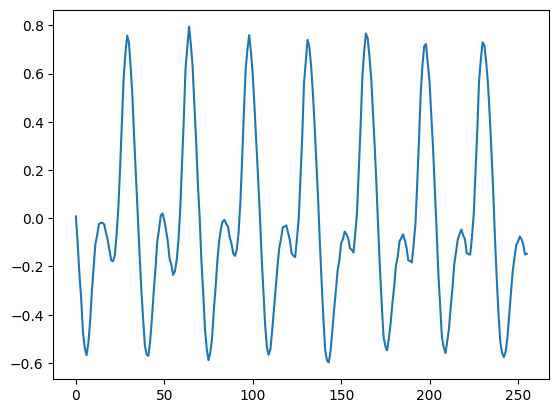

In [ ]:
plt.plot(sound[0][1000:1256])

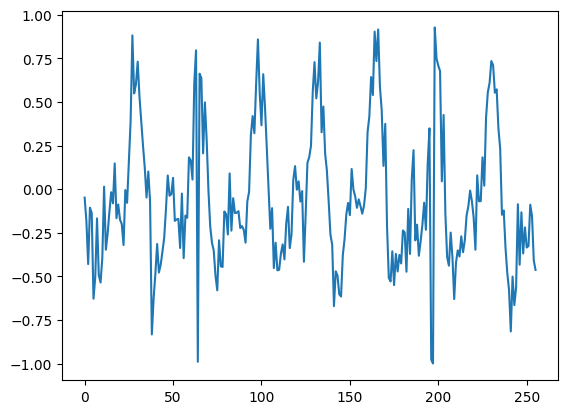

In [ ]:
plt.plot(noisy_sound[0][1000:1256])

In [ ]:
noisy_sound.shape

(5, 6144, 1)

In [ ]:
filtered = inferencia_modelo_novo.predict(noisy_sound.reshape(-1, 256, 24, 1))

1/1 [==============================] - 0s 101ms/step


In [ ]:
filtered.shape

(5, 6144, 1)

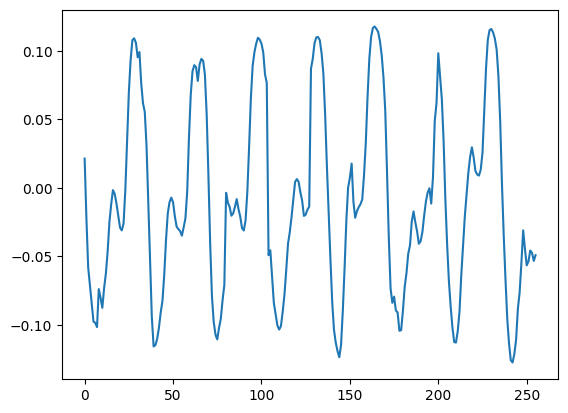

In [ ]:
filtered_sound = filtered.reshape(-1, 1)
plt.plot(filtered_sound[1000:1256])

In [ ]:
print('SNR sinal ruidoso: {}'.format(calculate_snr(sound, noisy_sound)))
print('SNR sinal filtrado: {}'.format(calculate_snr(sound, filtered)))

SNR sinal ruidoso: 2.1780332922935486
SNR sinal filtrado: 1.8349383771419525


In [ ]:
sound.reshape(-1).shape

(30720,)

In [ ]:
pesq(8000, sound[0].reshape(-1), filtered[0].reshape(-1), 'nb')

1.0310816764831543

In [ ]:
np.concatenate((sound[0], filtered[0]), axis=1).reshape(1, 6144,2).shape

(1, 6144, 2)

In [ ]:
pesq_net_score = modelo_treinado.predict(np.concatenate((sound[0], filtered[0]), axis=1).reshape(1, 6144,2))

1/1 [==============================] - 0s 14ms/step


In [ ]:
pesq_net_score * (4.6 +0.6) - 0.6

array([[1.0835648]], dtype=float32)